## Импорт библиотек и настройки

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import * 
from catboost import datasets

In [3]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.14.3
lightgbm @ file:///tmp/lightgbm/lightgbm-4.2.0-py3-none-manylinux_2_31_x86_64.whl#sha256=26ed21477c12bb26edc4d6d51336cd43d5a8f7daf55ebbe27b0faf50ce96db23
numpy @ file:///home/conda/feedstock_root/build_artifacts/numpy_1707225380409/work/dist/numpy-1.26.4-cp310-cp310-linux_x86_64.whl#sha256=51131fd8fc130cd168aecaf1bc0ea85f92e8ffebf211772ceb16ac2e7f10d7ca
pandas==2.1.4
pandas-datareader==0.10.0
pandas-profiling==3.6.6
pandas-summary==0.2.0
pandasql==0.7.3
scikit-learn==1.2.2
scikit-learn-intelex==2024.2.0
sklearn-pandas==2.2.0


In [4]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [241]:
train_df = pd.read_parquet("/kaggle/input/ready-data/train_ready.pqt")
test_df = pd.read_parquet("/kaggle/input/ready-data/test_ready.pqt")

## Анализ

Размерность

In [239]:
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

In [240]:
train_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,ogrn_year,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,okved,segment,sum_of_paym_2m,sum_of_paym_6m,sum_of_paym_1y,sum_a_oper_1m,cnt_a_oper_1m,sum_b_oper_1m,cnt_b_oper_1m,sum_c_oper_1m,cnt_c_oper_1m,sum_deb_d_oper_1m,cnt_deb_d_oper_1m,sum_cred_d_oper_1m,cnt_cred_d_oper_1m,sum_deb_e_oper_1m,cnt_deb_e_oper_1m,cnt_days_deb_e_oper_1m,sum_cred_e_oper_1m,cnt_cred_e_oper_1m,cnt_days_cred_e_oper_1m,sum_deb_f_oper_1m,cnt_deb_f_oper_1m,cnt_days_deb_f_oper_1m,sum_cred_f_oper_1m,cnt_cred_f_oper_1m,cnt_days_cred_f_oper_1m,sum_deb_g_oper_1m,cnt_deb_g_oper_1m,cnt_days_deb_g_oper_1m,sum_cred_g_oper_1m,cnt_cred_g_oper_1m,cnt_days_cred_g_oper_1m,sum_deb_h_oper_1m,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,sum_a_oper_3m,cnt_a_oper_3m,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_cred_e_oper_3m,cnt_days_cred_e_oper_3m,sum_deb_f_oper_3m,cnt_deb_f_oper_3m,cnt_days_deb_f_oper_3m,sum_cred_f_oper_3m,cnt_cred_f_oper_3m,cnt_days_cred_f_oper_3m,sum_deb_g_oper_3m,cnt_deb_g_oper_3m,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,40,1446,0,166,-0.488553,-0.135063,0,1,2.452182,2.736461,2.932560,2.437979,24,1,0.942275,0.536013,0.511490,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.128513,0.967030,-0.063678,0.221993,0.396523,0.893064,0.463405,0.505823,0.873795,0.623277,-0.125219,0.771335,0.212528,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,0.099899,0.226247,0.391439,1.054211,0.654057,0.387856,1.171020,0.648942,0.661628,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.143207,0.870124,-0.084701,0.307935,0.356556,0.426034,1.201541,0.435983,0.864246,1.270517,-0.152107,0.286074,0.891856,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.186820,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,3,{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,40,1446,0,166,-0.488553,-0.135063,0,1,2.469917,2.756014,2.952725,2.455375,24,1,0.645704,0.536378,0.486425,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.088209,0.969891,-0.063678,0.221993,0.131636,0.893042,0.398889,0.095082,0.873685,0.526503,-0.101797,0.771350,0.244786,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,-0.021465,0.224276,0.326923,0.419979,0.652830,0.258824,0.410410,0.633498,0.564854,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.127755,0.870983,-0.084701,0.307935,0.302226,0.425993,1.135607,0.411205,0.864251,1.237550,-0.142187,0.286081,0.902845,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.125043,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,3,{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,40,1446,0,166,-0.488553,-0.135063,0,1,2.485936,2.773674,2.970940,2.472771,24,1,0.403604,0.613167,0.480547,-0.188835,0.417022,-0.030225,0.435995,-0.103359,0.550798,-0.128513,0.967030,-0.063678,0.221993,0.485924,0.893049,0.560179,0.148894,0.873656,0.623277,-0.125219,0.771335,0.212528,-0.017983,0.154163,0.777702,-0.041418,0.513943,0.848818,-0.029795,0.223291,0.294665,1.251369,0.653444,0.387856,0.552757,0.629637,0.661628,-0.207082,0.208461,-0.029964,0.517298,-0.119654,0.960017,-0.127755,0.870983,-0.084701,0.307935,0.346818,0.425983,1.124618,0.280609,0.864190,1.226561,-0.142187,0.286081,0.902845,-0.025646,0.24851,0.038562,-0.040649,0.458055,0.728507,0.033607,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,3,{other}
3

Количество строк без пропусков

In [31]:
train_df.dropna().shape

(600000, 93)

In [32]:
test_df.dropna().shape

(272600, 92)

## Предобработка

Обозначение категориальных признаков

# Далее будет код для разных моделей
# Код для "числовых" моделей - это к примеру XGBClassifier, которому нужно обучиться на числовом end_claster,а код для обычных моделей - это к примеру для CatBoostClassifier, которому не нужно, чтобы end_claster был числом

# Для моделей "число"

In [242]:
cat_names = [
    "channel_code", "city", "city_type",
    "index_city_code", "ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster", "end_cluster"
]

In [209]:
label_encoders = {}

for col in cat_names:
    label_encoders[col] = LabelEncoder().fit(train_df[col])
    if col != "end_cluster":
        test_df[col] = label_encoders[col].transform(test_df[col])
    train_df[col] = label_encoders[col].transform(train_df[col])

# Для обычных моделей

In [243]:
cat_names = [
    "channel_code", "city", "city_type",
    "index_city_code", "ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster"
]

In [244]:
label_encoders = {}

for col in cat_names:
    label_encoders[col] = LabelEncoder().fit(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])
    train_df[col] = label_encoders[col].transform(train_df[col])

### Создаем выборки для валидации и обучения

Деление на обучающую и тестовую, исправляем дизбаланс классов, если не требуется, пропустить эти блоки до следующего текста

In [82]:
X = train_df.drop(["id", "date"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [65]:
# Calculate current class proportions
class_proportions = x_train['end_cluster'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.08].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.08
    current_count = (x_train['end_cluster'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count
    
    # Sample additional rows from the original dataset
    additional_samples = x_train[x_train['end_cluster'] == class_label].sample(n=additional_count, replace=True)
    additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    x_train = pd.concat([x_train] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(x_train['end_cluster'].value_counts(normalize=True))


end_cluster
{α}          0.237582
{}           0.091356
{α, η}       0.044737
{α, θ}       0.044737
{α, γ}       0.044737
{α, μ}       0.044737
{α, ε, θ}    0.044737
{α, ε}       0.044737
{α, ε, η}    0.044737
{other}      0.044737
{α, β}       0.044737
{α, δ}       0.044737
{α, ψ}       0.044737
{α, λ}       0.044737
{α, ε, ψ}    0.044737
{λ}          0.044737
{α, π}       0.044737
Name: proportion, dtype: float64


In [15]:
y_train = x_train['end_cluster']
x_train = x_train.drop(['end_cluster'], axis=1)
x_val = x_val.drop(['end_cluster'], axis=1)

In [16]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((480000, 90), (480000,), (120000, 90), (120000,))

# Деление на тестовую и обучающую выборку без дизбаланса

In [245]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение модели

Кросс-валидация для CatBoost (не нажимать если не разбираешься). Если не разбираешься, идти к следующему блоку текста

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 5,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, 
    stratified=True, 
    verbose=30
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Начало обучения

### CatBoostClassifier

In [257]:
model = CatBoostClassifier(iterations=1024,
                           depth=4,
                           learning_rate=0.075,
                           random_seed=43,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )

In [258]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):
    
    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15  # Через сколько итераций выводить статистику
    )
    model.save_model('catboost_model_15.json')  # Сохранение модели
    feature_importance = model.get_feature_importance(prettified=True)  # Датасет с важностью признаков
    
    return feature_importance

In [259]:
train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.2674260	test: 2.2683878	best: 2.2683878 (0)	total: 43.3ms	remaining: 44.3s
15:	learn: 1.1516118	test: 1.1547236	best: 1.1547236 (15)	total: 677ms	remaining: 42.6s
30:	learn: 0.9806305	test: 0.9836982	best: 0.9836982 (30)	total: 1.29s	remaining: 41.5s
45:	learn: 0.9262061	test: 0.9295224	best: 0.9295224 (45)	total: 1.9s	remaining: 40.4s
60:	learn: 0.9040834	test: 0.9066448	best: 0.9066448 (60)	total: 2.47s	remaining: 39s
75:	learn: 0.8901210	test: 0.8926719	best: 0.8926719 (75)	total: 3.06s	remaining: 38.1s
90:	learn: 0.8804609	test: 0.8831059	best: 0.8831059 (90)	total: 3.63s	remaining: 37.3s
105:	learn: 0.8732120	test: 0.8759120	best: 0.8759120 (105)	total: 4.22s	remaining: 36.5s
120:	learn: 0.8674042	test: 0.8702128	best: 0.8702128 (120)	total: 4.79s	remaining: 35.8s
135:	learn: 0.8622813	test: 0.8653768	best: 0.8653768 (135)	total: 5.39s	remaining: 35.2s
150:	learn: 0.8582114	test: 0.8613891	best: 0.8613891 (150)	total: 5.97s	remaining: 34.5s
165:	learn: 0.8545238	test: 

,Feature Id,Importances
0,start_cluster,16.469493
1,okved,7.335280
2,segment,6.801505
3,sum_deb_e_oper_1m,5.188127
4,balance_amt_min,4.602507
5,channel_code,3.024361
6,balance_amt_max,2.798407
7,cnt_days_deb_e_oper_3m,2.673161
8,sum_cred_e_oper_3m,2.648128
9,sum_deb_e_oper_3m,2.617992


Модель LGBM, блоки кода не нажимать чтобы не сбросилась model CatBoost. Я еще не тестил эту модель, переходи к метрикам

### LGBM

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

### XGBClassifier

In [211]:
%%time
model = XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')
model.fit(x_train, y_train)

CPU times: user 53 s, sys: 321 ms, total: 53.3 s
Wall time: 46.3 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Ансамблевые модели

In [248]:
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
%%time
base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                     depth=4,
                                     learning_rate=0.075,
                                     random_seed=43,
                                     loss_function='MultiClass',
                                     task_type="GPU",
                                     devices='0',
                                     early_stopping_rounds=20,
                                     verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist'))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)

model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=1)

model.fit(x_train, y_train)

# Ансамбль 2

In [250]:
%%time
base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                     depth=4,
                                     learning_rate=0.075,
                                     random_seed=43,
                                     loss_function='MultiClass',
                                     task_type="GPU",
                                     devices='0',
                                     early_stopping_rounds=20,
                                     verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')),
    ('extra_trees', ExtraTreesClassifier(n_estimators=50, max_depth=3, random_state=42),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)

model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

model.fit(x_train, y_train)

0:	learn: 2.2803487	total: 20.6s	remaining: 5h 50m 50s
500:	learn: 0.8354803	total: 31.4s	remaining: 32.8s
1000:	learn: 0.8129828	total: 42.1s	remaining: 968ms
1023:	learn: 0.8123820	total: 42.6s	remaining: 0us
0:	learn: 2.2806307	total: 23.5ms	remaining: 24.1s
500:	learn: 0.8352770	total: 9.23s	remaining: 9.63s
1000:	learn: 0.8121979	total: 18.2s	remaining: 419ms
1023:	learn: 0.8113967	total: 18.7s	remaining: 0us
0:	learn: 2.2804007	total: 22.1ms	remaining: 22.6s
500:	learn: 0.8348691	total: 9.27s	remaining: 9.68s
1000:	learn: 0.8112723	total: 18.2s	remaining: 418ms
1023:	learn: 0.8105430	total: 18.6s	remaining: 0us
0:	learn: 2.2802114	total: 22.7ms	remaining: 23.2s
500:	learn: 0.8349362	total: 9.2s	remaining: 9.6s
1000:	learn: 0.8129179	total: 18.2s	remaining: 418ms
1023:	learn: 0.8121034	total: 18.6s	remaining: 0us
0:	learn: 2.2805666	total: 22.2ms	remaining: 22.8s
500:	learn: 0.8349371	total: 9.18s	remaining: 9.58s
1000:	learn: 0.8117935	total: 18.2s	remaining: 418ms
1023:	learn: 0

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7afb1a0333d0>),
                               ('lgbm',
                                LGBMClassifier(max_depth=3, n_jobs=-1,
                                               random_state=42,
                                               tree_method='gpu_hist',
                                               verbosity=-1)),
                               ('extra_trees',
                                ExtraTreesClassifier(max_depth=3,
                                                     n_estimators=50,
                                                     random_state=42))],
                   final_estimator=RandomForestClassifier(max_depth=5,
                                                          n_estimators=50,
                                                          random_state=42))

# Графики для моделей "число"

In [212]:
y_train = pd.Series(label_encoders["end_cluster"].inverse_transform(y_train),  name='end_claster')
y_val = pd.Series(label_encoders["end_cluster"].inverse_transform(y_val),  name='end_claster')

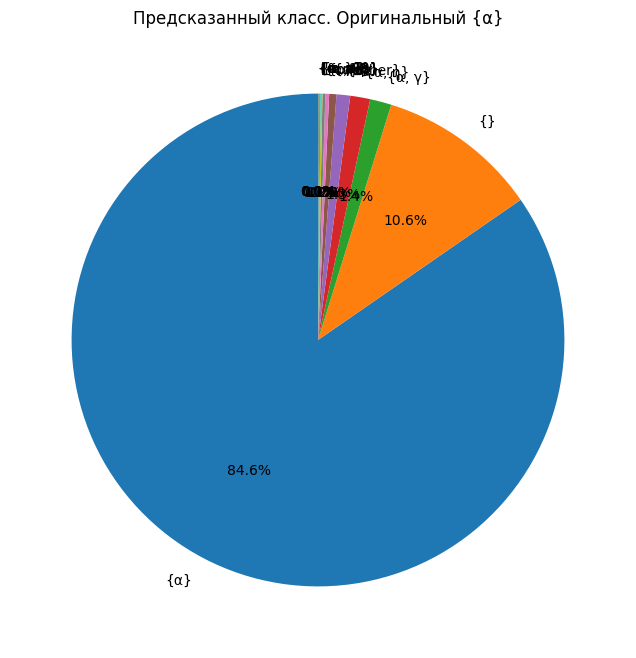

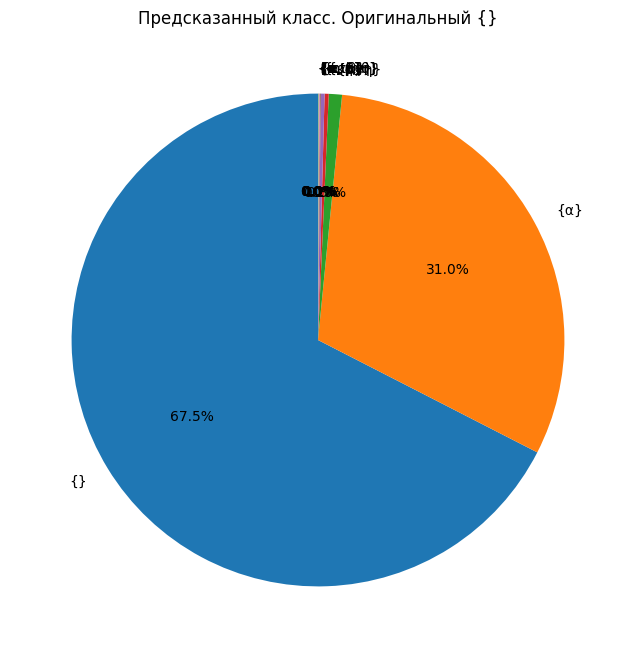

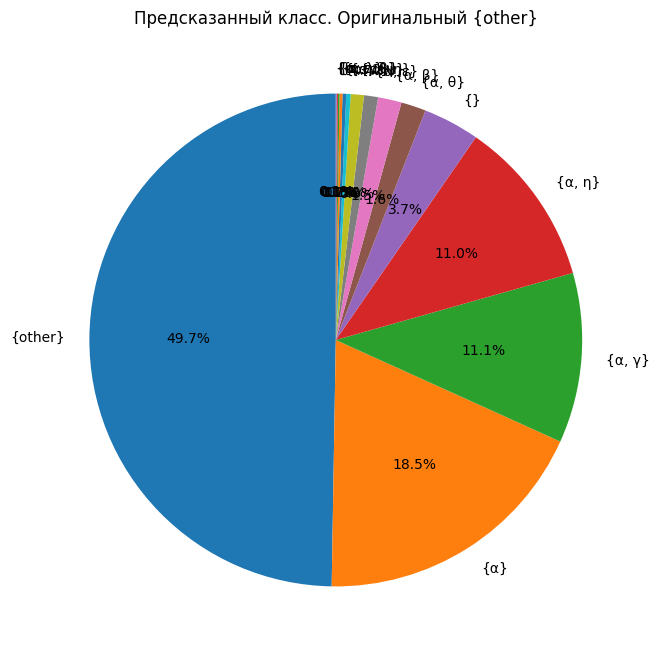

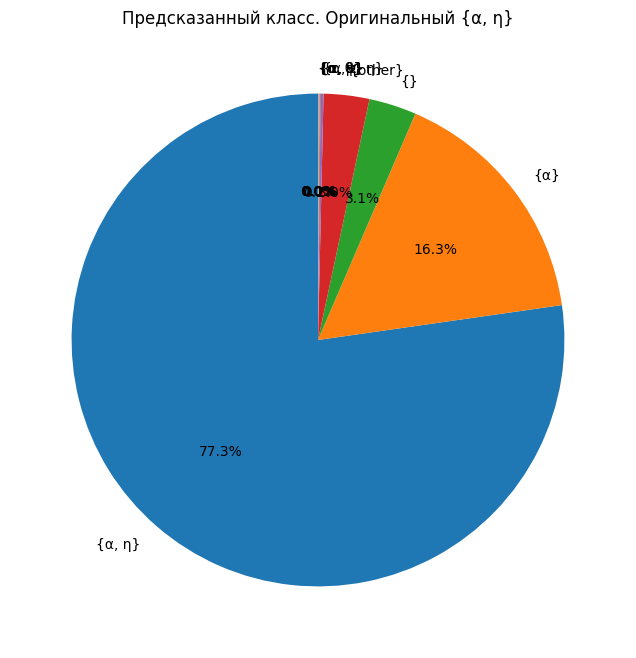

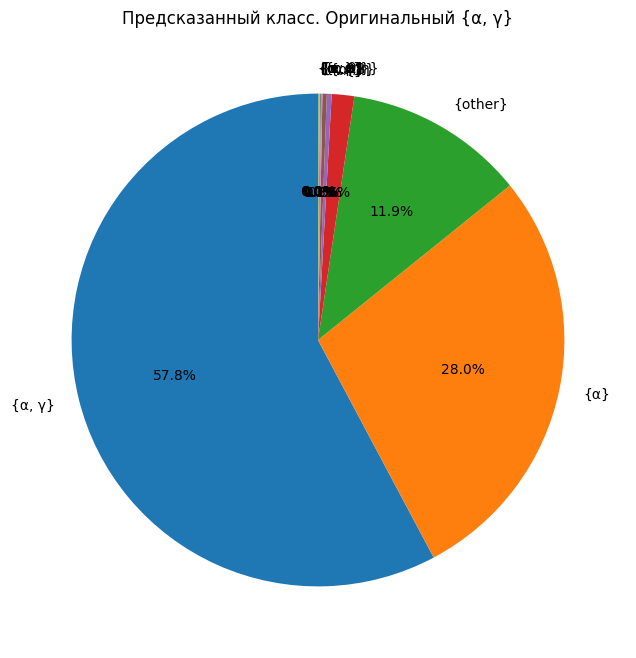

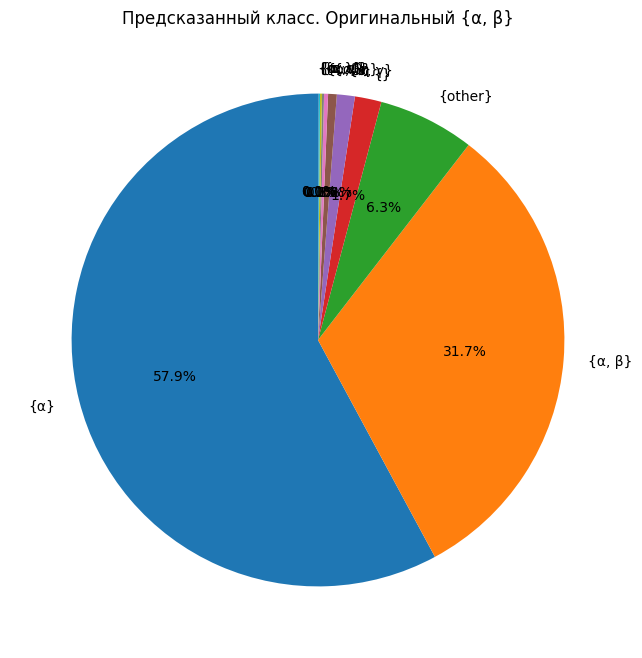

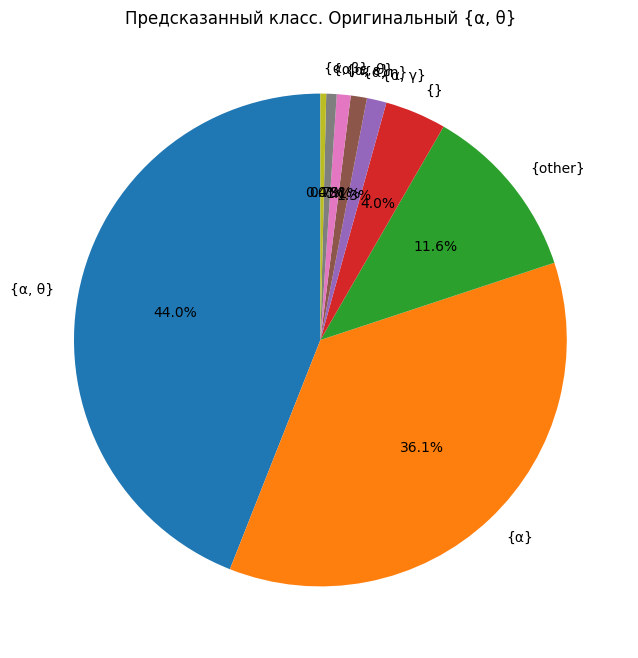

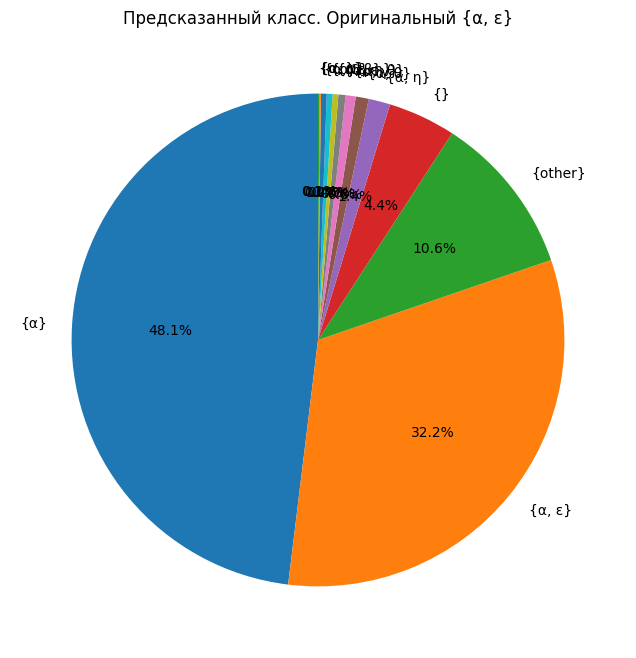

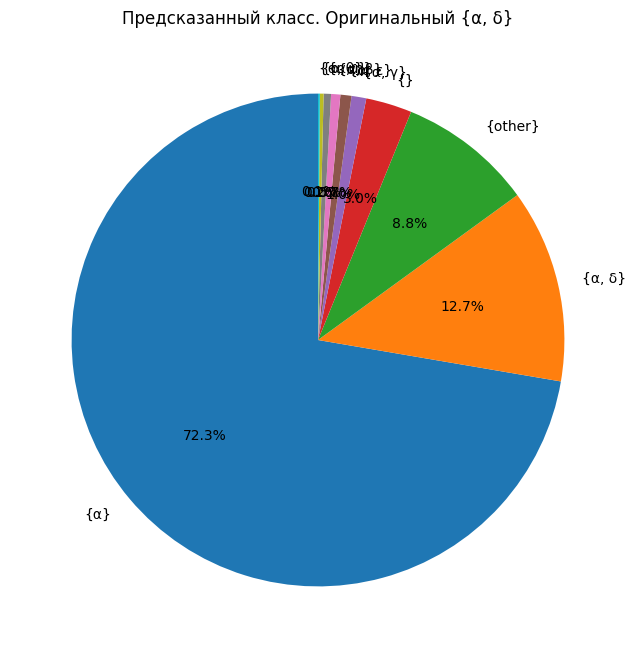

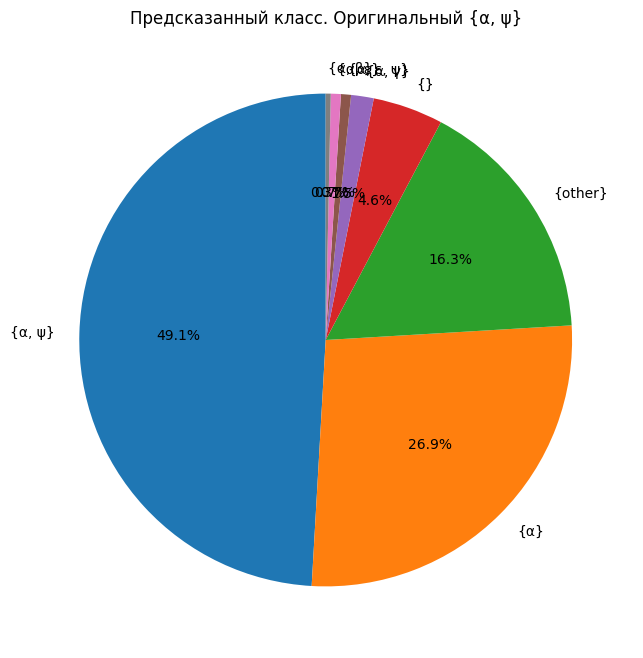

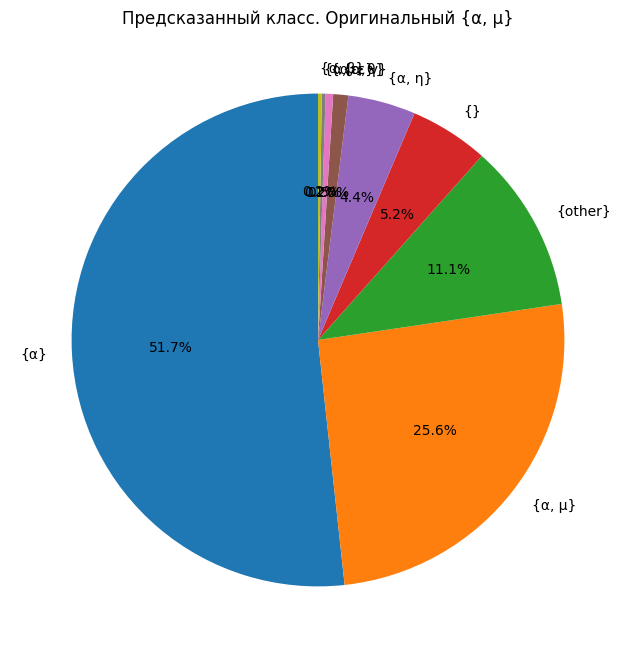

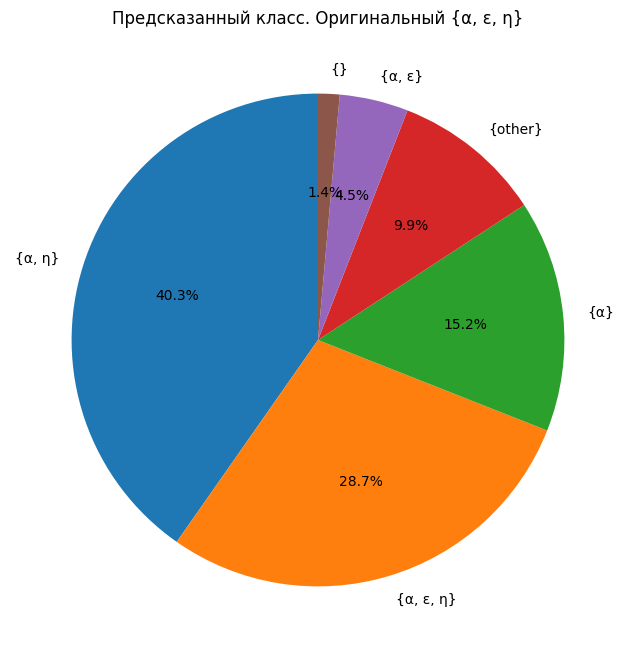

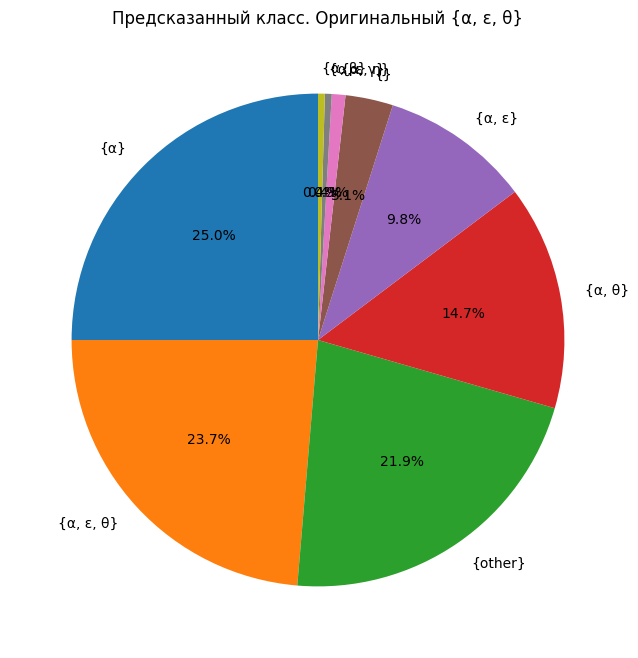

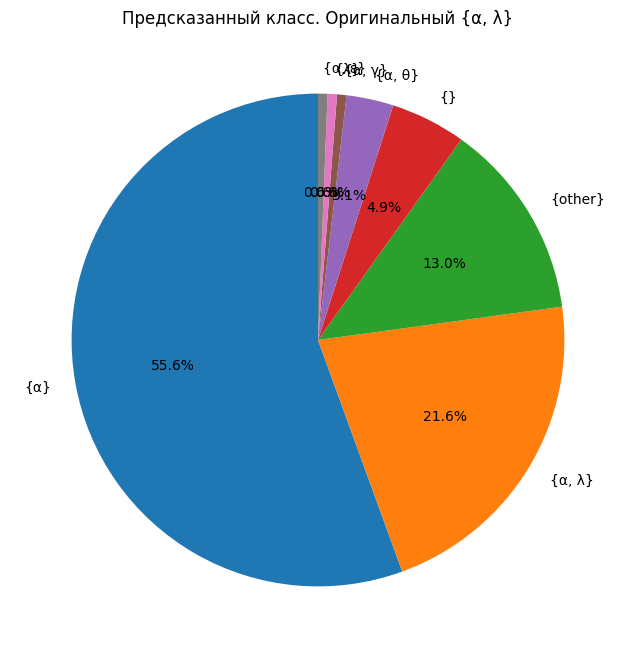

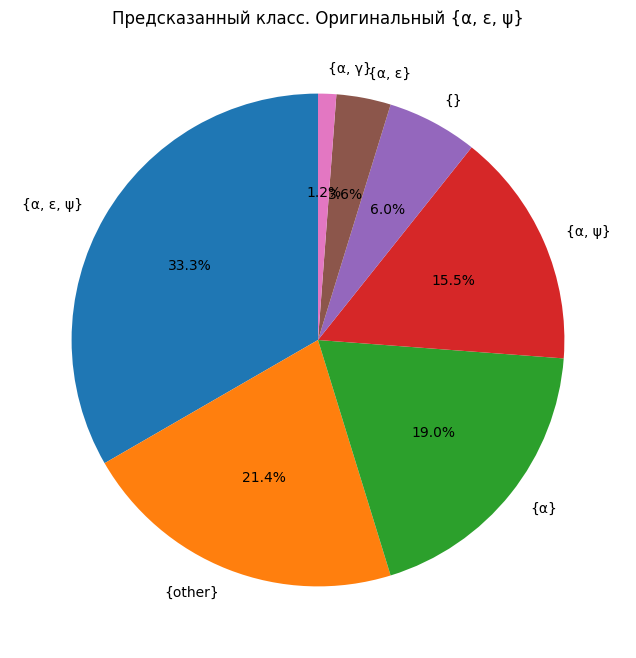

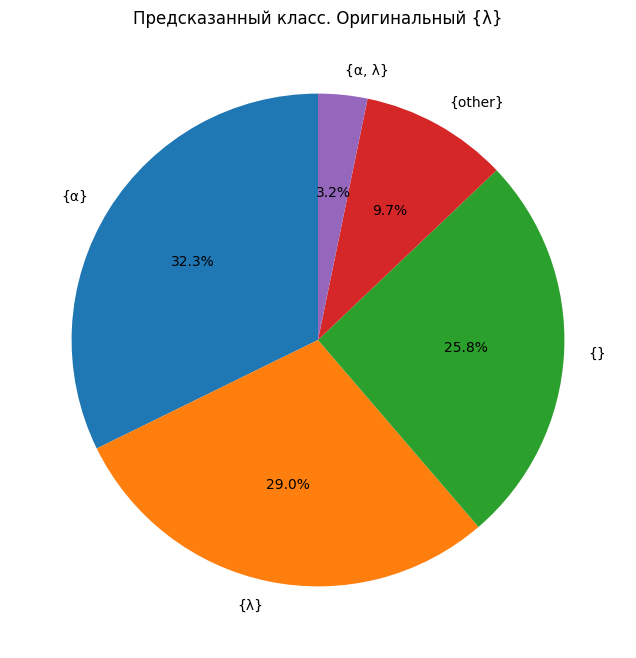

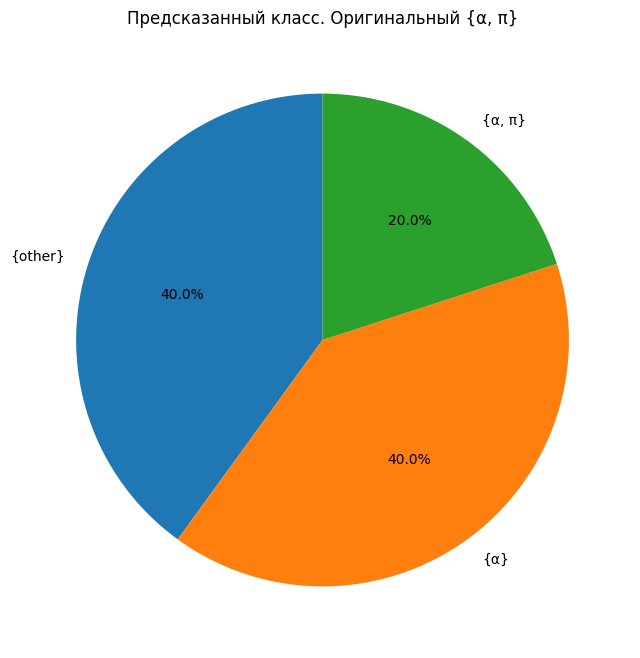

In [213]:
y_pred = model.predict(x_val)
y_pred = label_encoders["end_cluster"].inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred)
y_pred[1] = y_val.reset_index(drop=True)

list_of_classes = y_pred[1].value_counts().index
for clas in list_of_classes:
    data = y_pred[y_pred[1] == clas][0].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(data.values, labels=data.keys(), autopct='%1.1f%%', startangle=90)
    plt.title(f'Предсказанный класс. Оригинальный {clas}')
    plt.show()

# Графики для обычных моделей 

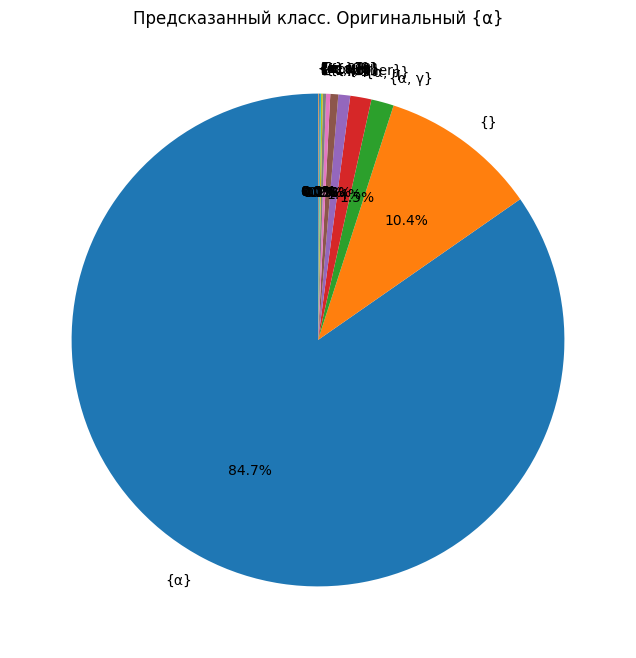

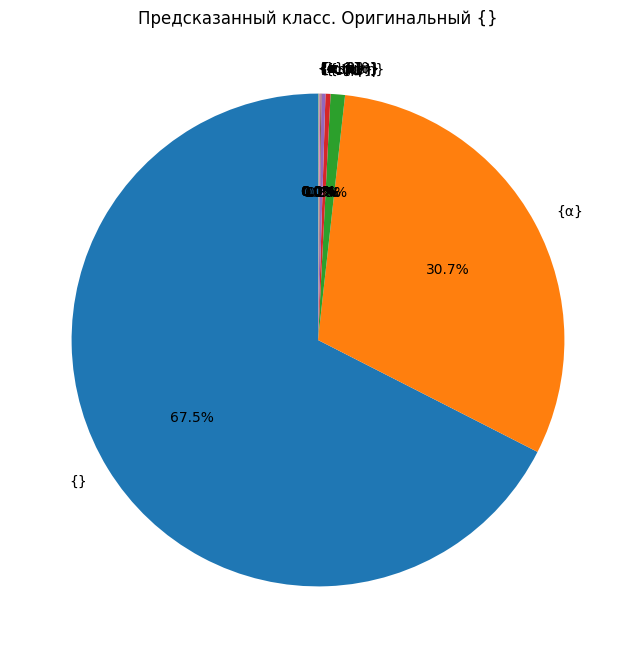

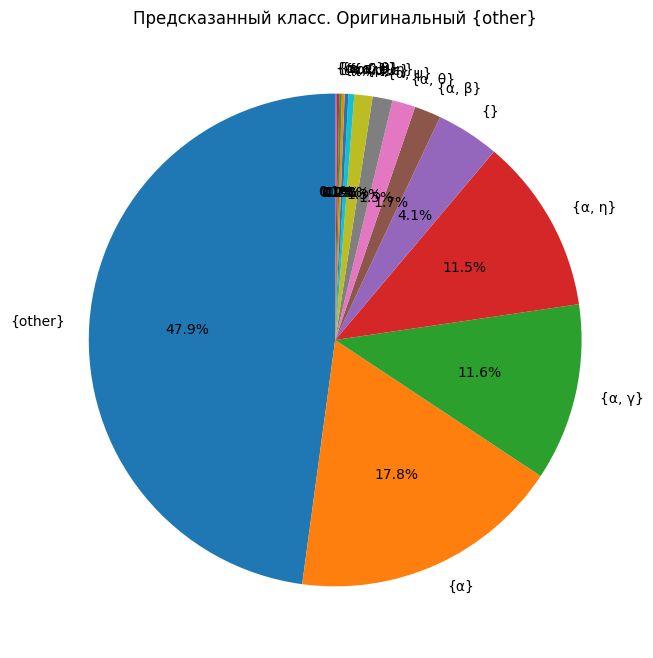

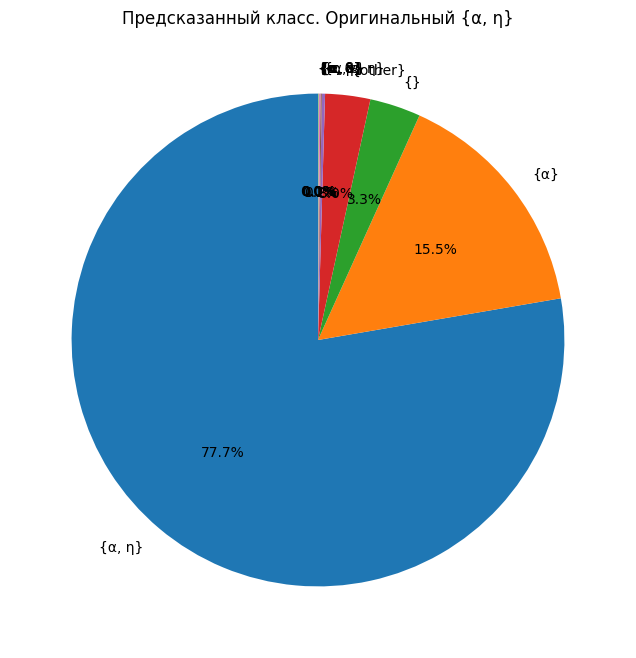

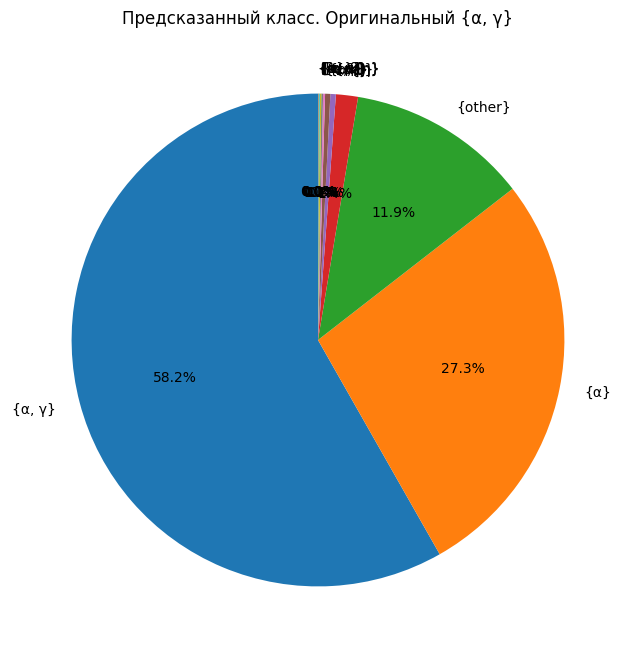

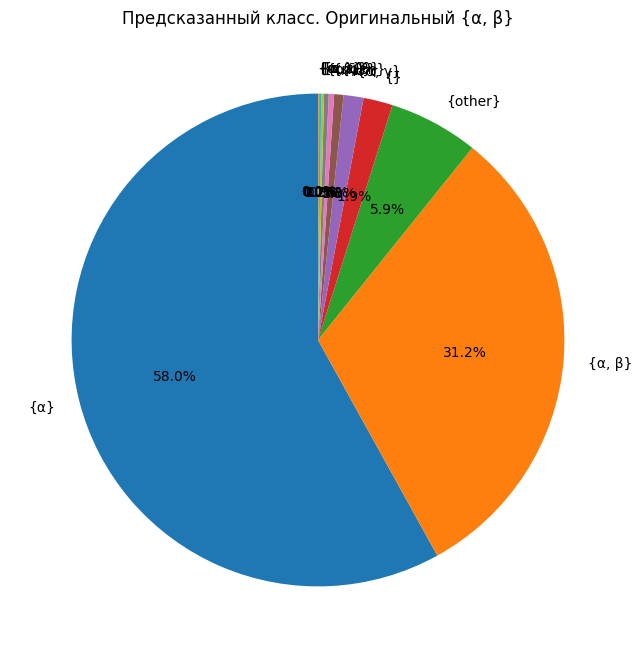

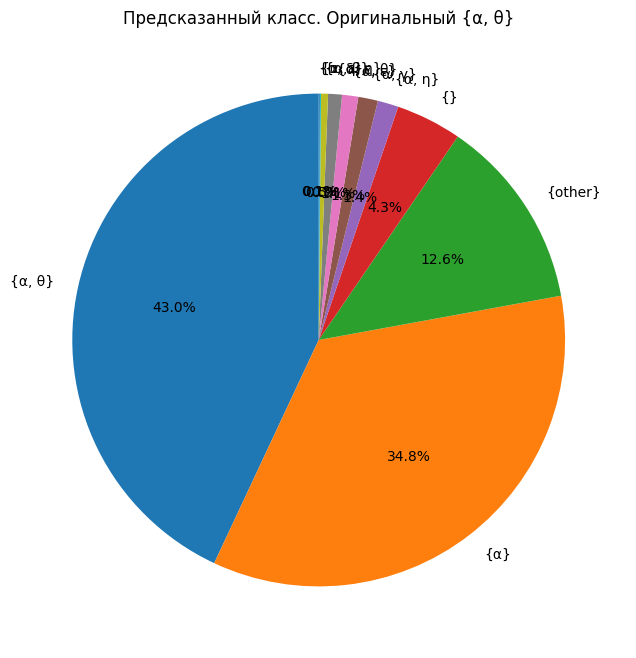

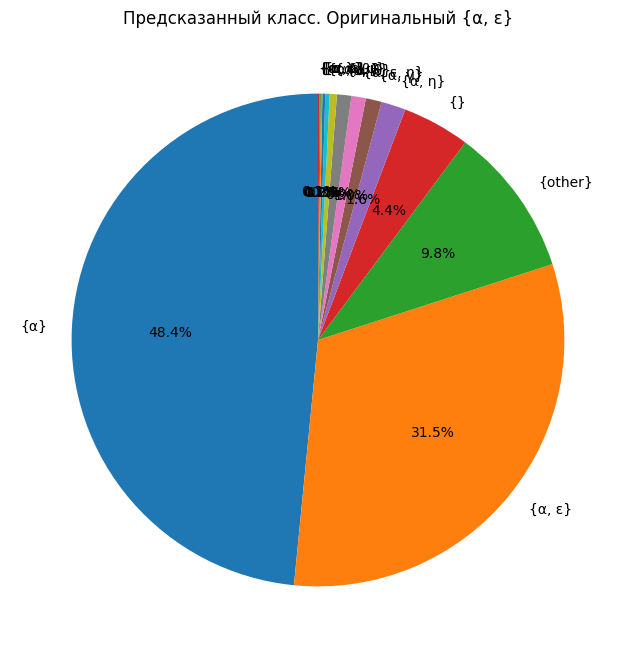

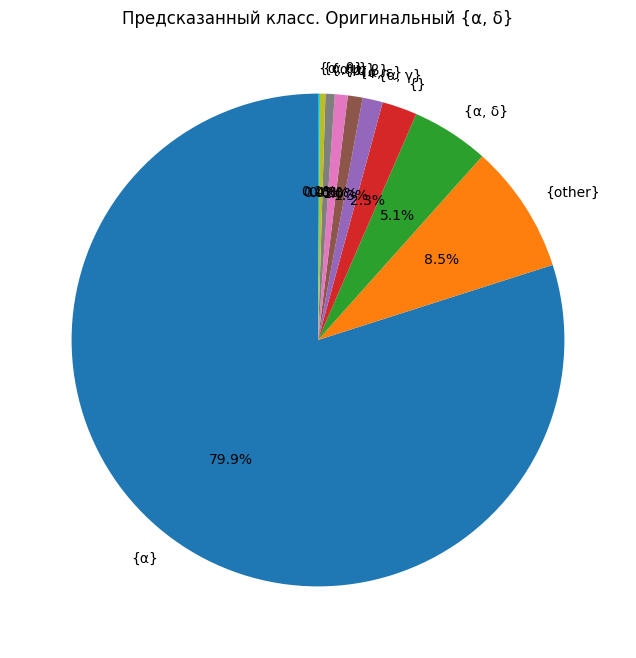

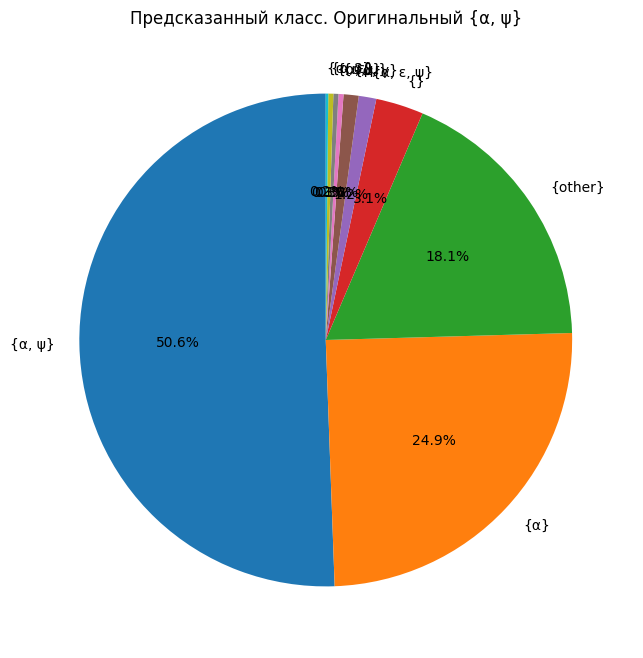

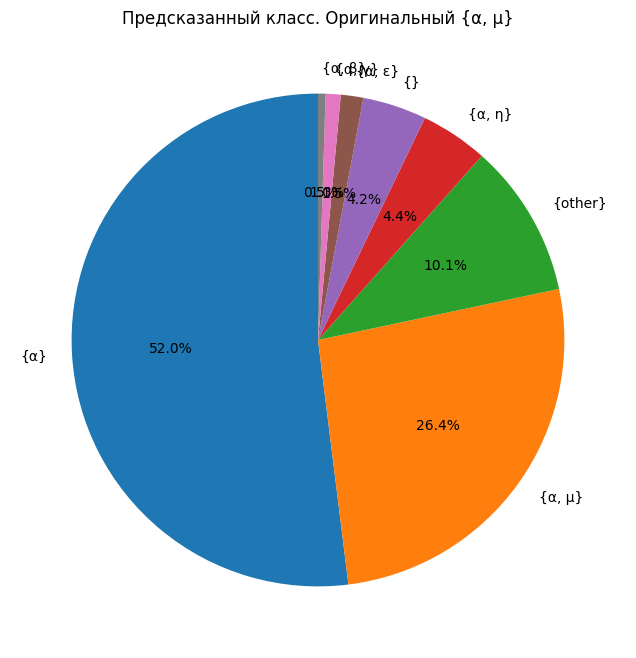

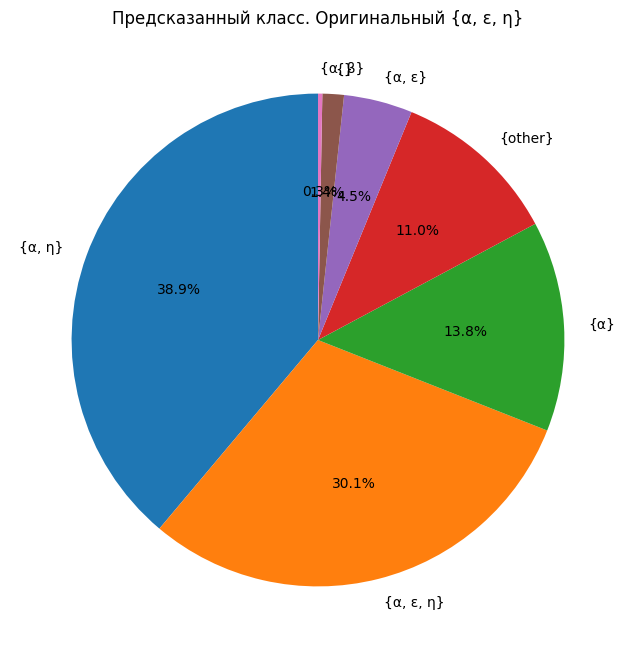

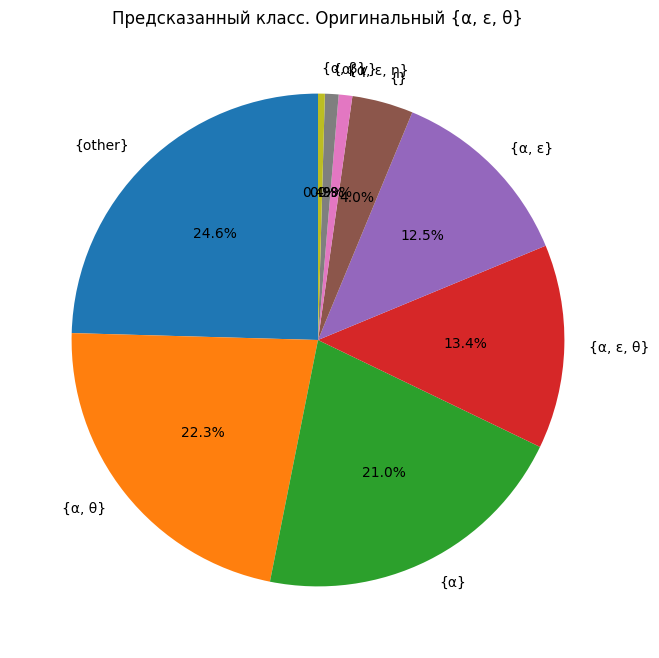

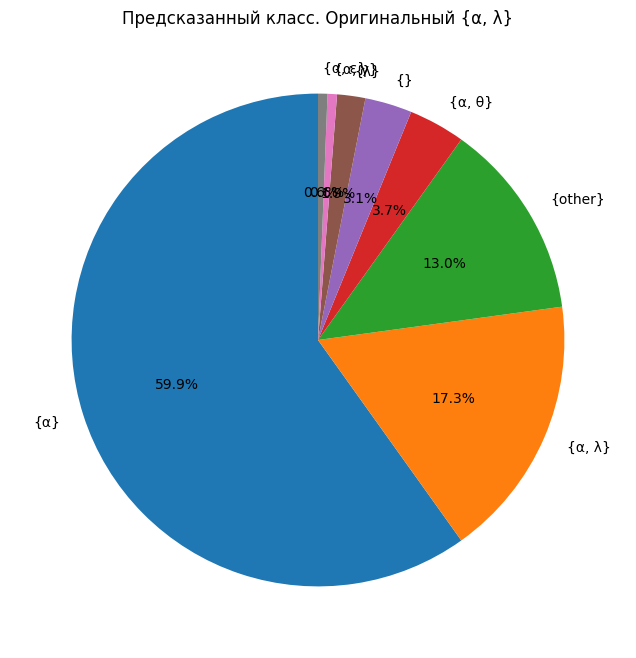

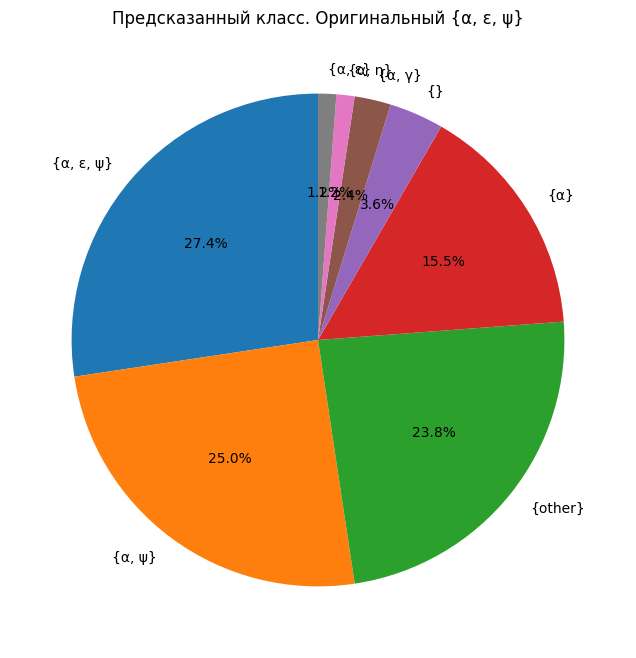

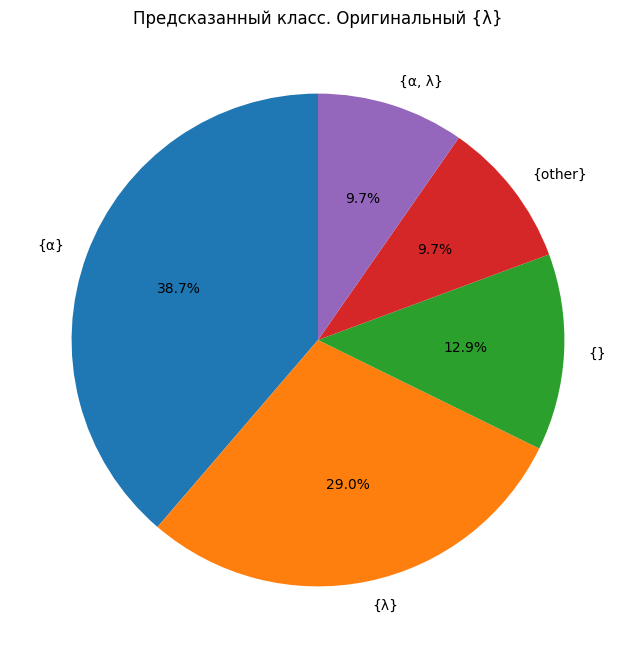

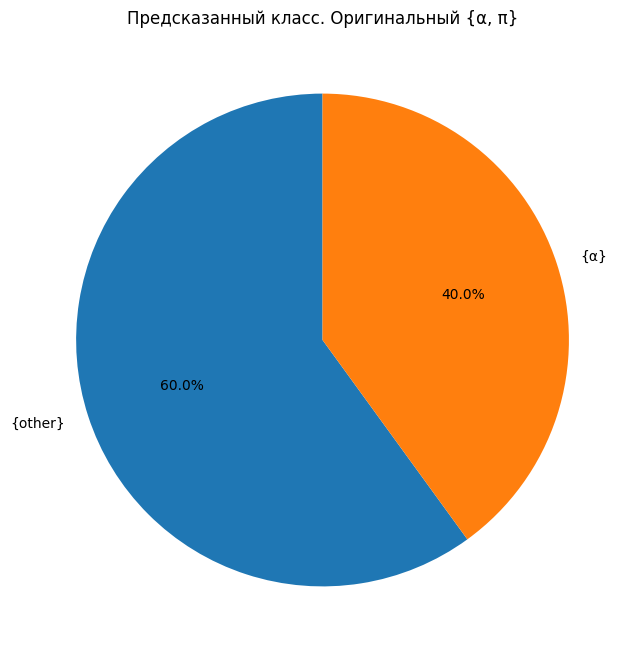

In [260]:
y_pred = model.predict(x_val)
y_pred = pd.DataFrame(y_pred)
y_pred[1] = y_val.reset_index(drop=True)

list_of_classes = y_pred[1].value_counts().index
for clas in list_of_classes:
    data = y_pred[y_pred[1] == clas][0].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(data.values, labels=data.keys(), autopct='%1.1f%%', startangle=90)
    plt.title(f'Предсказанный класс. Оригинальный {clas}')
    plt.show()

# Метрики для моделей "число"

In [214]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    labels = label_encoders["end_cluster"].inverse_transform(labels)
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

# Метрики для обычных моделей 

In [261]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [262]:
cluster_weights = pd.read_excel("/kaggle/input/data-xlsx/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [263]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [264]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9197177384208994

## Прогноз на тестовой выборке для моделей "число"

In [218]:
sample_submission_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv") 
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

test_pred_proba = model.predict_proba(last_m_test_df)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=label_encoders["end_cluster"].inverse_transform(model.classes_))
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_1_10.csv", index=False) 

## Прогноз на тестовой выборке для обычных моделей

In [265]:
sample_submission_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv") 
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

test_pred_proba = model.predict_proba(last_m_test_df) 
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_1_13.csv", index=False) 

In [266]:
sample_submission_df.shape  # Если (100000, 18), то все правильно

(100000, 18)

In [267]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.008952,0.021961,0.017972,0.022737,0.006810,0.000161,0.001699,0.000233,0.009759,0.004096,0.014480,0.000416,0.002401,0.000003,0.002638,0.885680,0.000004
1,200001,0.006624,0.515304,0.000755,0.002521,0.000544,0.000110,0.000494,0.000010,0.001467,0.004963,0.001753,0.000384,0.000868,0.000002,0.000621,0.463396,0.000183
2,200002,0.589248,0.005758,0.005013,0.104986,0.012340,0.001401,0.004187,0.017108,0.037170,0.009966,0.019878,0.002753,0.005819,0.000004,0.046307,0.138009,0.000055
3,200003,0.025446,0.613454,0.000578,0.001359,0.000411,0.000720,0.000362,0.000023,0.000937,0.019278,0.001917,0.000077,0.001299,0.000003,0.000249,0.333867,0.000020
4,200004,0.082233,0.162188,0.007675,0.026006,0.007251,0.002333,0.000633,0.000080,0.008655,0.058790,0.003626,0.000418,0.003476,0.000006,0.001013,0.635562,0.000054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.016540,0.312660,0.002368,0.005242,0.002390,0.000118,0.000473,0.000011,0.001220,0.002445,0.001954,0.000755,0.000273,0.000048,0.000798,0.652537,0.000169
99996,299996,0.021337,0.035319,0.017189,0.034656,0.005156,0.000305,0.000639,0.000057,0.009092,0.005760,0.009285,0.003097,0.002455,0.000029,0.002193,0.853343,0.000089
99997,299997,0.026725,0.026728,0.021421,0.073189,0.012387,0.000205,0.001777,0.000980,0.011909,0.004867,0.006453,0.001607,0.003180,0.000024,0.013346,0.795196,0.000005
99998,299998,0.073864,0.224319,0.011156,0.057629,0.002882,0.003172,0.000931,0.000335,0.017420,0.072676,0.011665,0.000658,0.001536,0.000068,0.005783,0.515631,0.000276
